# Steps to reproduce this environment to be able to use openmm-torch
Disclaimer: All solutions and fixes were suggestions found in github forums adapted for the present problem.

1. Install pytorch 1.13.0 (preferrable from conda-forge channel), using CUDA 11.7 version.
2. Install openmm from conda as well
3. Try to install openmm-torch with conda
4. Fail and die
5. Rise from the ashes like a phoenix and install openmm-torch from source like a pro (steps to install below) (to confirm if we need to install from source)
6. Install caffee from conda
7. Add the following env variables: `export LD_LIBRARY_PATH=/path/to/caffe2/build/lib:$LD_LIBRARY_PATH` and `export LD_LIBRARY_PATH=/usr/local/cuda-9.0/lib64:$LD_LIBRARY_PATH`
8. By this point you will have to recompile openmm-torch
9. In my case (Maybe not needed at all) had to uninstall pytorch and install it again.

Note: You need to import torch before importing openmmtorch, otherwise some features won't work

### Steps to install openmm-torch from source

1. Go to `https://pytorch.org/get-started/locally/` and select the combination: Stable, Linux, Libtorch, C++/Java, CUDA 11.7, and copy the command below the description "Download here (cxx11 ABI):". Then change the version from 2.0.1 to 1.13.0. Or alternatively, just copy the following command in the terminal: `wget https://download.pytorch.org/libtorch/cu117/libtorch-shared-with-deps-1.13.0%2Bcu117.zip`
2. unzip the zipped file
3. Make sure the folder where you unzipped libtorch (The thing downloaded above) is accessible from where you're going to build openmm-torch
4. Clone locally the repo https://github.com/openmm/openmm-torch
5. write in the terminal `ccmake openmm-torch`
6. In the interactive terminal, set `PYTORCH_DIR` to point to the directory where you installed the LibTorch.
7. Set `OPENMM_DIR` to point to the directory where OpenMM is installed. This is needed to locate the OpenMM header files and libraries. If you are unsure of what directory this is, the following script will print it out. Set the `CMAKE_INSTALL_PREFIX` to point to the same directory as the `OPENMM_DIR`.
8. Set the `CUDA_TOOLKIT_ROOT_DIR` because in this case we need it. And make sure `NN_BUILD_CUDA_LIB` is selected. In our case we also selected the flags `NN_BUILD_OPENCL_LIB`, `NN_BUILD_PYTHON_WRAPPERS` and the `CUDNN_STATIC`.
9. If it's the first time configuring the build, you may need to press the "configure" `[c]` option twice. After that the "generate" `[g]` option will appear. If the progress percentage reaches 100%


In [1]:
import torch
from openmmtorch import TorchForce
import os

import yaml
from pathlib import Path


import numpy as np
from openmm.app import *
from openmm import *
from openmm.unit import *
# from force_mapper import ForceMapper

# import mdtraj as md

import training_modules as tm
from sys import stdout

from simutils import ForceReporter, ForceModelConvert

In [2]:
current_dir = os.getcwd()
fmartip_dir = os.path.dirname(current_dir)
dataset_dir = os.path.dirname(fmartip_dir)
output_file = os.path.join(dataset_dir, "enere@usi.ch/CGffap/dataset.VoidNoPBC.npz")  #fmartip/ff-naive/DatasetsA2A/dataset.A2a.hydrogen.pose0.npz
dataset = dict(np.load(output_file))
# Prepare a simulation system
atomic_numbers = dataset['atom_types']
# output_file = os.path.join(dataset_dir, "sorted.bond.chig.indices.npz")  # sorted.bond.a2a.indices.npz
# bond_indices = np.load(output_file)
# # bond_indices = np.array([[14, 18], [0, 3], [6, 7], [0, 5], [19, 21]])
# dataset['bond_indices'] = np.array(bond_indices['arr_0']).reshape(-1,2)
# config_file = os.path.join(dataset_dir, "config.naive.bonds.yaml")
# conf_bonds: list = yaml.safe_load(Path(config_file).read_text())
# config_file = os.path.join(dataset_dir, "config.naive.angles.yaml")
# conf_angles: list = yaml.safe_load(Path(config_file).read_text())
# config_file = os.path.join(dataset_dir, "config.naive.dihedrals.yaml")
# conf_dihedrals: list = yaml.safe_load(Path(config_file).read_text())

In [3]:
torch.cuda.set_device(0)

In [4]:
dataset.keys()

dict_keys(['num_residues', 'resnames', 'residcs', 'resnumbers', 'num_atoms', 'atom_pos', 'atom_resnames', 'atom_names', 'atom_types', 'atom_residcs', 'atom_resnumbers', 'ATOM_SEGIDS', 'atom_forces', 'num_beads', 'bead_pos', 'bead_idnames', 'bead_resnames', 'bead_names', 'bead_types', 'bead_residcs', 'bead_resnumbers', 'bead_segids', 'bead_forces', 'pbc', 'bead2atom_idcs', 'bead2atom_weights'])

In [5]:
dataset['pbc']

array([ True,  True,  True])

In [6]:
for k, v in dataset.items():
    try:
        print(k, v.shape)
    except:
        print(k)

num_residues ()
resnames (10,)
residcs (10,)
resnumbers (10,)
num_atoms ()
atom_pos (9100, 165, 3)
atom_resnames (165,)
atom_names (165,)
atom_types (165,)
atom_residcs (165,)
atom_resnumbers (165,)
ATOM_SEGIDS (165,)
atom_forces (9100, 165, 3)
num_beads ()
bead_pos (9100, 32, 3)
bead_idnames (32,)
bead_resnames (32,)
bead_names (32,)
bead_types (32,)
bead_residcs (32,)
bead_resnumbers (32,)
bead_segids (32,)
bead_forces (9100, 32, 3)
pbc (3,)
bead2atom_idcs (32, 13)
bead2atom_weights (32, 13)


In [7]:
index = 0
# bead mass calculation
bead_mass_dict = []
name_index = 0

for atoms in dataset["bead2atom_idcs"]:
    # print(i)
    bead_mass = 0
    num_atoms = 0
    for j in atoms:
        atom_name = dataset['atom_names'][j]
        if  "C" in atom_name:
            atom_mass = 12
            bead_mass += 12
        elif "O" in atom_name:
            atom_mass = 16
            bead_mass += 16
        elif "N" in atom_name:
            atom_mass = 14
            bead_mass += 14
        elif "S" in atom_name:
            atom_mass = 32
            bead_mass += 32
        elif "H" in atom_name:
            atom_mass = 1
            bead_mass += 1
        num_atoms += 1
    bead_mass_dict.append(bead_mass)
    # force_matrix[index] = force_matrix[index] / bead_mass * num_atoms
    name_index += 1
    index += 1
dataset['bead_mass'] = bead_mass_dict

In [8]:

pdb_file = os.path.join(dataset_dir,  "/home/enere@usi.ch/FMartIP/ChigCG.pdb" ) #'/home/enere@usi.ch/FMartIP/original_CG_A2A.pdb' "ChignCG_unfolded.pdb" "original_CG_A2A.pdb" "chig_CG/original_CG_a2a_Water.pdb" 
# "/home/enere@usi.ch/FMartIP/chig_CG/original_CG_a2a_4.pdb"
pdb = PDBFile(pdb_file) # OpenMM loader

In [9]:
# pdb = PDBFile('/home/enere@usi.ch/CGffap/temp/chignolin_unfolded_frames0.pdb') # OpenMM loader

In [10]:
pdb.getPositions() == pdb.positions

True

In [11]:
bead_mass_dict = {}
name_index = 0
for mass in dataset['bead_mass']:
    bead_mass_dict[dataset['bead_idnames'][name_index]] = mass
    name_index += 1

bead_mass_dict

{'TYR_BB': 63,
 'TYR_SC1': 35,
 'TYR_SC2': 35,
 'TYR_SC4': 39,
 'TYR_SC3': 35,
 'ASP_BB': 63,
 'ASP_SC1': 65,
 'PRO_BB': 63,
 'PRO_SC1': 46,
 'GLU_BB': 63,
 'GLU_SC1': 76,
 'THR_BB': 63,
 'THR_SC1': 50,
 'GLY_BB': 63,
 'TRP_BB': 63,
 'TRP_SC1': 35,
 'TRP_SC2': 37,
 'TRP_SC3': 35,
 'TRP_SC5': 35,
 'TRP_SC4': 35}

In [12]:
dataset['bead_types']

array([ 1, 37, 38, 40, 39,  1, 37, 38, 40, 39,  1,  6,  1, 29,  1, 10,  1,
       31,  1,  1, 31,  1, 32, 33, 34, 36, 35,  1, 37, 38, 40, 39])

In [13]:
index = 0
for atom, bead in zip(pdb.topology.atoms(), np.unique(dataset['bead_idnames'])):
    # print(chr(index + 150))
    i = dataset['bead_types'][np.where(dataset['bead_idnames'] == bead)]
    print(i[0]+100)
    mass = bead_mass_dict[bead]
    print(mass*amu)
    print(bead)
    try:
        atom.element = Element(number = i[0]+100, name = bead, symbol = str(index), mass = mass*amu)
    except:
        atom.element = Element.getByAtomicNumber(i[0]+100)
    index +=1
    print(Element.getByAtomicNumber(i[0]+100))
    print(chr(index))

101
63 Da
ASP_BB
<Element ASP_BB>

106
65 Da
ASP_SC1
<Element ASP_SC1>

101
63 Da
GLU_BB
<Element ASP_BB>

110
76 Da
GLU_SC1
<Element GLU_SC1>

101
63 Da
GLY_BB
<Element ASP_BB>

101
63 Da
PRO_BB
<Element ASP_BB>

129
46 Da
PRO_SC1
<Element PRO_SC1>

101
63 Da
THR_BB
<Element ASP_BB>

131
50 Da
THR_SC1
<Element THR_SC1>
	
101
63 Da
TRP_BB
<Element ASP_BB>


132
35 Da
TRP_SC1
<Element TRP_SC1>

133
37 Da
TRP_SC2
<Element TRP_SC2>

134
35 Da
TRP_SC3
<Element TRP_SC3>

135
35 Da
TRP_SC4
<Element TRP_SC4>

136
35 Da
TRP_SC5
<Element TRP_SC5>

101
63 Da
TYR_BB
<Element ASP_BB>

137
35 Da
TYR_SC1
<Element TYR_SC1>

138
35 Da
TYR_SC2
<Element TYR_SC2>

139
35 Da
TYR_SC3
<Element TYR_SC3>

140
39 Da
TYR_SC4
<Element TYR_SC4>



In [14]:
bead_charges = []
for bead in dataset['bead_names']:
    if bead == 'GLU_SC1' or bead == 'ASP_SC1' :
        bead_charges.append(-1)
    elif bead == 'ARG_SC2' or bead == 'HIS_SC3' or bead == 'LYS_SC2':
        bead_charges.append(+1)
    else:
        bead_charges.append(0)
print(bead_charges)
dataset['bead_charges'] = np.asanyarray(bead_charges).reshape(-1,1)
np.matmul(dataset['bead_charges'], dataset['bead_charges'].T)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [15]:
for atom in pdb.topology.atoms():
    atom
    break

In [16]:
atom.element.mass

Quantity(value=63, unit=dalton)

In [17]:
system = System()

for atom in pdb.topology.atoms():
    # print(atom)
    # print(dataset['bead_mass'][atom.index])
    system.addParticle(atom.element.mass)

# boxVectors = pdb.topology.getPeriodicBoxVectors()
# if boxVectors is not None:
#     system.setDefaultPeriodicBoxVectors(boxVectors[0], boxVectors[1], boxVectors[2])
# print(boxVectors)
system.usesPeriodicBoundaryConditions()

False

In [18]:
model = torch.jit.load('/home/enere@usi.ch/CGffap/best_model_chig9900mixframesNH2000epochs.pt')

# force =  torch.jit.script(ForceModelConvert(model, 10.))

# force.save('modeltrain2.pt')

In [19]:
model.state_dict()

OrderedDict([('dispertion_const',
              tensor([2.9199e+00, 3.0721e+00, 2.9652e+00, 3.2558e+00, 3.3272e+00, 6.0621e+00,
                      1.2012e+01, 8.5532e+00, 3.7670e+00, 3.2660e+00, 1.2479e+01, 2.2093e+00,
                      3.3031e+00, 3.0427e+00, 3.0543e+00, 3.0674e+00, 3.0533e+00, 3.0491e+00,
                      3.0532e+00, 2.7441e+00, 3.1564e+00, 2.9316e+00, 1.4675e+00, 2.9541e+00,
                      3.0387e+00, 8.2746e+00, 2.9701e+00, 1.5217e+01, 3.4802e-03, 1.0837e+01,
                      8.6705e+00, 9.1227e+00, 2.9062e+00, 1.1911e+01, 3.6140e+00, 3.3188e+00,
                      3.0751e+00, 2.9275e+00, 3.4002e+00, 2.9847e+00, 3.4247e+00, 3.0814e+00,
                      3.2041e+00, 2.4947e+00, 2.7721e+00, 2.9727e+00, 2.9562e+00, 2.8772e+00,
                      3.0276e+00, 2.7420e+00, 2.4214e+00, 1.1945e-02, 3.5473e+00, 8.9001e-03,
                      4.9628e+00, 3.4032e+00, 2.6158e+00, 2.8454e+00, 2.7634e+00, 2.9356e+00,
                      2.72

In [20]:
# torch.cuda.set_device(1)
# print(torch.cuda.current_device())

In [37]:
# SUCCESSFUL TRIAL WITHOUT FORCES AND WITHOUT BONDS (EMPTY SYSTEM WITH JUST THE PARTICLES)

# pdb_file = '/home/enere@usi.ch/FMartIP/ChigCG.pdb'
# pdb = PDBFile(pdb_file) # OpenMM loader
# pdb.topology = Topology()
# pdb.topology.addAtom(dataset['bead_names'][0], "bead", "TRY")

# gro = GromacsGroFile('/home/enere@usi.ch/FMartIP/ChigCG.gro')
# top = GromacsTopFile('/home/enere@usi.ch/FMartIP/ChigCGtopol.top')
# top.setPeriodicBoxVectors(gro.getPeriodicBoxVectors())

# modeller = Modeller(top,gro.positions)

# Save the NNP to a file and load it with OpenMM-Torch
# torch.jit.script(potential).save('model.pt')
# force = TorchForce('model.pt', {'useCUDAGraphs': 'true'})
# force = TorchForce('modeltrain.pt')
force = TorchForce('/home/enere@usi.ch/CGffap/bestmodelchigtestboard.pt') #'/home/enere@usi.ch/CGffap/bestmodelchigtestboard.pt'
#

# I would need to still create the empty system
# forcefield = ForceField('amber14-all.xml')
# system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME, nonbondedCutoff=1*nanometer, constraints=None)
# integrator = LangevinIntegrator(300*kelvin, 1/picoseconds , 0.005 * picoseconds)

integrator =VerletIntegrator( 0.010*picoseconds) # NoseHooverIntegrator(300*kelvin, 1/picosecond, 0.010*picoseconds) #
#
#NoseHooverIntegrator(300*kelvin, 1/picosecond, 0.010*picoseconds)


while system.getNumForces() > 0:
    system.removeForce(0)
    
# The system should not contain any additional force and constrains
assert system.getNumConstraints() == 0
assert system.getNumForces() == 0

# Add the NNP to the system
system.addForce(force)

# This line combines the molecular topology, system, and integrator to begin a new simulation. It creates a Simulation object and assigns it to a variable called simulation. 
# A Simulation object manages all the processes involved in running a simulation, such as advancing time and writing output.
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.getPositions())

# Performs a local energy minimization. It is usually a good idea to do this at the start of a simulation, since the coordinates in the PDB file might produce very large forces.
# simulation.minimizeEnergy()
print("starting Sim")

simulation.reporters.append(PDBReporter('output.pdb', 10))
simulation.reporters.append(StateDataReporter('output.dat', 10, step=True, potentialEnergy=True, kineticEnergy=True, temperature=True, time=True, totalEnergy=True))
simulation.reporters.append(ForceReporter('outputforces.txt', 10))

#This line adds another reporter to print out some basic information every 1000 time steps
simulation.step(10000)
state = simulation.context.getState(getPositions=True, getEnergy=True, getForces=True)
f = np.array([[a.x,a.y,a.z]for a in state.getForces()])
p = np.array([[a.x,a.y,a.z]for a in state.getPositions()])
# print(state.getForces(), state.getPositions())

starting Sim


ValueError: Particle position is NaN.  For more information, see https://github.com/openmm/openmm/wiki/Frequently-Asked-Questions#nan

In [ ]:
np.linalg.norm(pdb.positions[0]-pdb.positions[1])

Quantity(value=0.28517177279667777, unit=nanometer)

In [23]:
state = simulation.context.getState(getPositions=True, getEnergy=True, getForces=True)
np.array([[a.x,a.y,a.z]for a in state.getForces()])

array([[-6.98112030e+01, -1.14019951e+02, -1.49613190e+02],
       [-1.84358307e+02,  7.95520096e+01, -6.07092361e+01],
       [ 2.09198486e+02, -1.09226456e+01,  7.52234497e+01],
       [-6.78211136e+01, -4.20476913e+01,  5.05157471e+01],
       [ 1.55320969e+02,  4.60710182e+01,  1.21761131e+02],
       [ 5.04671097e-01,  1.34712524e+02, -5.25794449e+01],
       [-7.99279633e+01,  7.78059692e+01, -1.02273415e+02],
       [ 3.46150627e+01,  3.46918907e+01, -4.68689537e+01],
       [-3.55086823e+01,  2.99515629e+01, -3.23330879e+00],
       [ 7.01212311e+00,  2.12118301e+01,  2.61664524e+01],
       [ 1.53727970e+01,  4.38389091e+01,  3.89506378e+01],
       [ 3.39016724e+00, -5.79199295e+01, -3.48085976e+01],
       [ 6.62115631e+01, -2.25414734e+01, -9.67852631e+01],
       [ 1.49305534e+00,  1.26680573e+02,  8.89150543e+01],
       [ 1.29718781e+02,  9.94371948e+01,  1.61291885e+00],
       [-9.70287933e+01, -3.01457920e+01,  5.97446327e+01],
       [-4.08401031e+01, -1.32043060e+02

In [25]:
poses = torch.Tensor(p).to('cuda')

In [26]:
model = torch.jit.load('/home/enere@usi.ch/CGffap/bestmodelchigtestboard.pt')
model_forces = model(poses)

In [ ]:
# forcemodel = tm.ForceMapper(model, dataset=dataset, pdb_path= '/home/enere@usi.ch/CGffap/pro.pdb')

# forcemodel(poses).detach().cpu().numpy() == np.array([[a.x,a.y,a.z]for a in state.getForces()])

In [27]:
output_file = os.path.join(dataset_dir, "enere@usi.ch/CGffap/dataset.notVoid.npz")  #fmartip/ff-naive/DatasetsA2A/dataset.A2a.hydrogen.pose0.npz
dataset = dict(np.load(output_file))

In [28]:
np.linalg.norm(dataset['bead_forces'],axis=0).max()

34054.33928623185

In [29]:
dataset_void = dict(np.load('/home/enere@usi.ch/CGffap/dataset.VoidNoPBC.npz'))
np.linalg.norm(dataset_void['bead_forces'],axis=0).max()

19078.327876550014

In [30]:
simForces = np.linalg.norm(np.array(simulation.reporters[2].getForces()),axis=-1)
beadForces = np.linalg.norm(dataset['bead_forces'][:len(simForces)],axis=-1)
beadForces_void = np.linalg.norm(dataset_void['bead_forces'][:len(simForces)],axis=-1)

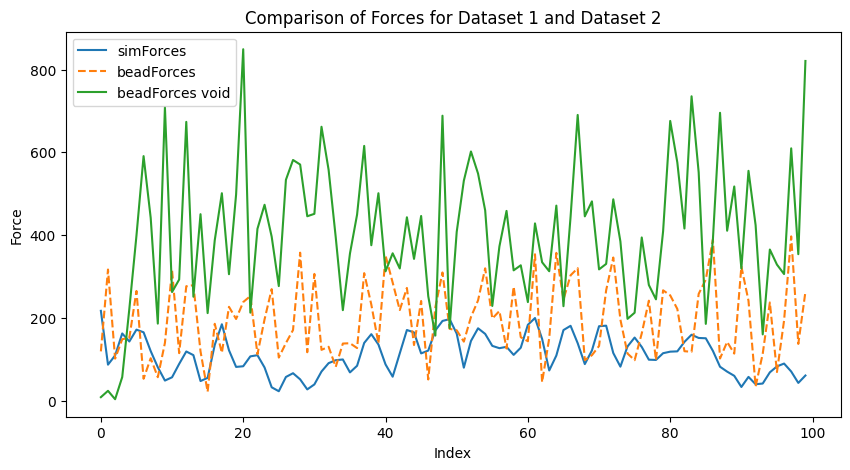

In [31]:
# Plot losses
import matplotlib.pyplot as plt
selected_bead_index = 10
# Plotting dataset 1
plt.figure(figsize=(10, 5))
plt.plot(simForces[:,selected_bead_index], label='simForces')


# Plotting dataset 2
plt.plot(beadForces[:,selected_bead_index], linestyle='--', label='beadForces')

# Plotting dataset 3
plt.plot(beadForces_void[:,selected_bead_index], label='beadForces void')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Force')
plt.title('Comparison of Forces for Dataset 1 and Dataset 2')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
state = simulation.context.getState(getPositions=True, getEnergy=True, getForces=True)

state.getForces()

Quantity(value=[Vec3(x=-1579.8739013671875, y=-5805.24853515625, z=1377.3292236328125), Vec3(x=30926.830078125, y=15395.025390625, z=15333.708984375), Vec3(x=55374.8359375, y=25280.3046875, z=12952.5146484375), Vec3(x=-142824.96875, y=-60372.10546875, z=-35916.1796875), Vec3(x=50878.765625, y=21314.2421875, z=7656.283203125), Vec3(x=653.4158325195312, y=2480.02587890625, z=-4200.8720703125), Vec3(x=-82498.0078125, y=-25669.177734375, z=-14240.6650390625), Vec3(x=-42202.1015625, y=-5667.802734375, z=-5831.48681640625), Vec3(x=-84415.65625, y=-22940.68359375, z=-16695.84375), Vec3(x=214463.53125, y=55968.53125, z=39443.28125), Vec3(x=3518.125, y=-1165.225341796875, z=2753.751708984375), Vec3(x=-90.65547943115234, y=-2602.423095703125, z=1184.9969482421875), Vec3(x=-10435.724609375, y=-875.2655029296875, z=-4883.25634765625), Vec3(x=9334.259765625, y=3747.03369140625, z=471.8678894042969), Vec3(x=1295.7015380859375, y=4004.0234375, z=-5097.162109375), Vec3(x=556.2909545898438, y=-270.1701